In [1]:
%cd /content/drive/MyDrive/Colab/instate_v2/

/content/drive/MyDrive/Colab/instate_v2


In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from fastprogress import master_bar, progress_bar

In [3]:
# Load the data
df = pd.read_csv('data/final/all_states_with_languages_agg.csv')

In [4]:
df.head()

,last_name,sindhi,nepali,kannada,marathi,mizo,adi,garo,tagin,assamese,...,telugu,malayalam,tamil,meitei,khasi,gondi,bodo,nishi,chakma,pahari and kumauni
0,aadhumull,0.000,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
1,bachhar,0.500,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bachhodiya,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bachhole,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,balait,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop Nan values
df.dropna(inplace=True)

In [6]:
agg_dict = {col: 'sum' for col in df.columns if col != 'last_name'}
df = df.groupby('last_name').agg(agg_dict).reset_index()

In [7]:
df.head()

,last_name,sindhi,nepali,kannada,marathi,mizo,adi,garo,tagin,assamese,...,telugu,malayalam,tamil,meitei,khasi,gondi,bodo,nishi,chakma,pahari and kumauni
0,aadhumull,0.000,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
1,bachhar,0.500,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bachhodiya,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bachhole,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,balait,0.125,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.shape

(783089, 38)

In [87]:
# Function to check if a string contains only English characters
def contains_english(s):
    return s.isalpha() and all(c.isascii() for c in s)  # Checks if all characters are ASCII

In [89]:
# Filter the rows that do not have English characters in the last_name column
df = df[df['last_name'].apply(contains_english)]

In [91]:
# consider only names that are more than 2 chars
df = df[df['last_name'].str.len() > 2]

In [92]:
# Splitting data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [93]:
train_df.to_csv('data/final/train.csv', index=False)
val_df.to_csv('data/final/val.csv', index=False)
test_df.to_csv('data/final/test.csv', index=False)

In [94]:
# load train_df, val_df and test_df
train_df = pd.read_csv('data/final/train.csv')
val_df = pd.read_csv('data/final/val.csv')
test_df = pd.read_csv('data/final/test.csv')

## Loading dataset

In [95]:
class LangDataset(Dataset):
    def __init__(self, dataframe, char2idx):
        self.data = dataframe
        self.last_names = self.data['last_name'].values
        self.labels = self.data.drop(['last_name'], axis=1).values.astype(float)
        self.char2idx = char2idx

        # Normalize the labels
        # self.scaler = StandardScaler()
        # self.scaler = MinMaxScaler()
        # self.labels = self.scaler.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        last_name = self.last_names[idx]
        last_name_indices = [self.char2idx[char] for char in last_name]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        return {'last_name': torch.tensor(last_name_indices, dtype=torch.long), 'labels': labels}

In [96]:
# Generate Character to Index Mapping
chars = set()
for name in df['last_name']:
    chars.update(name)
char2idx = {char: idx + 1 for idx, char in enumerate(chars)}
char2idx['<PAD>'] = 0
idx2char = {idx: char for char, idx in char2idx.items()}

In [98]:
# Creating datasets and dataloaders
train_dataset = LangDataset(train_df, char2idx)
val_dataset = LangDataset(val_df, char2idx)
test_dataset = LangDataset(test_df, char2idx)

In [99]:
# display first sample of train_dataset
first_element = train_dataset[0]

# Convert character indices back to the actual characters
last_name_characters = ''.join([idx2char[char.item()] for char in first_element['last_name']])

# Print first element details
print("First element in the train dataset:")
print("Last Name (Character Indices):", first_element['last_name'])
print("Last Name (Characters):", last_name_characters)
print("Labels:", first_element['labels'])

First element in the train dataset:
Last Name (Character Indices): tensor([12, 17, 10, 23,  3, 14, 17, 10])
Last Name (Characters): bhinathi
Labels: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


In [100]:
def collate_fn(samples):
    last_names = [sample['last_name'] for sample in samples]
    labels = torch.stack([sample['labels'] for sample in samples])
    lengths = torch.tensor([len(name) for name in last_names])
    last_names_padded = pad_sequence(last_names, batch_first=True, padding_value=0)
    return {'last_names': last_names_padded, 'labels': labels, 'lengths': lengths}

In [101]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [102]:
# Get the first batch
first_batch = next(iter(train_loader))

# Print the content of the first batch
print("First batch in the train DataLoader:")
print("Last Names (Character Indices):", first_batch['last_names'])
print("Labels:", first_batch['labels'])
print("Lengths:", first_batch['lengths'])

# Convert the character indices back to characters for the first few names in the batch
for i in range(min(3, len(first_batch['last_names']))):  # printing only the first three for brevity
    last_name_indices = first_batch['last_names'][i]
    last_name_characters = ''.join([idx2char[char.item()] for char in last_name_indices if char != 0])
    print(f"Last Name {i+1} (Characters):", last_name_characters)

First batch in the train DataLoader:
Last Names (Character Indices): tensor([[ 7,  3,  3, 18, 10,  5,  5,  3, 23, 14, 17, 10,  0,  0],
        [20,  3,  4,  6, 14, 21,  0,  0,  0,  0,  0,  0,  0,  0],
        [14, 26, 22, 17, 23, 10, 26,  8,  3, 18,  0,  0,  0,  0],
        [ 6,  3, 18, 10, 23,  3,  0,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3, 20, 17,  3, 13,  3,  7,  3,  4,  0,  0,  0],
        [ 5,  4,  3, 15,  3, 23, 10,  7,  7,  0,  0,  0,  0,  0],
        [20, 26, 26, 20, 10, 15,  3, 23, 10,  0,  0,  0,  0,  0],
        [22,  3, 21, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  3,  7,  1,  1,  4,  3,  5,  5,  3, 19, 26, 18,  3],
        [17, 26, 19,  3,  4,  3, 14, 10,  0,  0,  0,  0,  0,  0],
        [12,  3, 23,  3, 19,  3,  3, 23,  6,  3,  7,  3,  4,  3],
        [ 7,  3, 23, 10, 19,  3, 14, 14, 21,  0,  0,  0,  0,  0],
        [20, 17,  3,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 7,  3, 22, 10, 15, 10, 20,  3,  0,  0,  0,  0,  0,  0],
       

## Model

In [103]:
class LangModel_v2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LangModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=0.3, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1,:,:]  # Get the output of the last LSTM layer
        h_n = self.batch_norm(h_n)  # Apply batch normalization
        h_n = self.dropout(h_n)
        output = self.fc(h_n)
        return output

In [104]:
class LangModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LangModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        output = self.fc(h_n)
        return output

In [105]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [106]:
# Initialize model, loss function, optimizer
vocab_size = len(char2idx)
embedding_dim = 50
hidden_dim = 128
output_dim = 37
lr = 0.0005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LangModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs=100
early_stopper = EarlyStopper(patience=10)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)

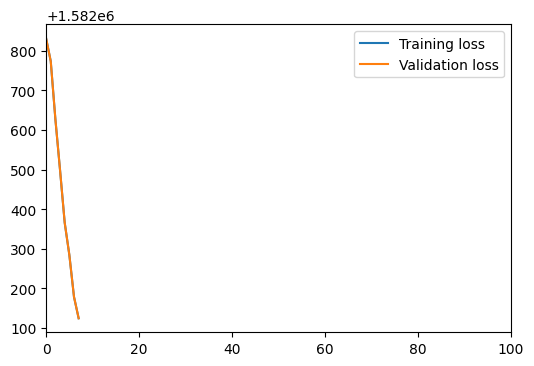

Validation loss decreased (inf --> 23845152.000000).  Saving model ...
Validation loss decreased (23845152.000000 --> 23844940.000000).  Saving model ...
Validation loss decreased (23844940.000000 --> 23844562.000000).  Saving model ...
Validation loss decreased (23844562.000000 --> 23843902.000000).  Saving model ...
Validation loss decreased (23843902.000000 --> 23843730.000000).  Saving model ...


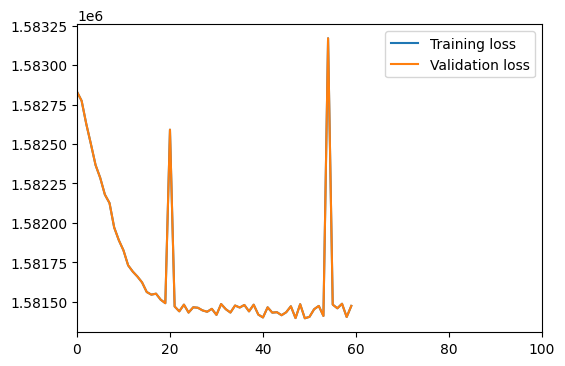

Validation loss decreased (23843730.000000 --> 23843692.000000).  Saving model ...
Validation loss decreased (23843692.000000 --> 23843688.000000).  Saving model ...
Validation loss decreased (23843688.000000 --> 23843686.000000).  Saving model ...
Validation loss decreased (23843686.000000 --> 23843680.000000).  Saving model ...
Validation loss decreased (23843680.000000 --> 23843678.000000).  Saving model ...
Validation loss decreased (23843678.000000 --> 23843676.000000).  Saving model ...
Validation loss decreased (23843676.000000 --> 23843672.000000).  Saving model ...
Validation loss decreased (23843672.000000 --> 23843670.000000).  Saving model ...
Validation loss decreased (23843670.000000 --> 23843670.000000).  Saving model ...
Validation loss decreased (23843670.000000 --> 23843670.000000).  Saving model ...
Validation loss decreased (23843670.000000 --> 23843670.000000).  Saving model ...
Validation loss decreased (23843670.000000 --> 23843670.000000).  Saving model ...
Vali

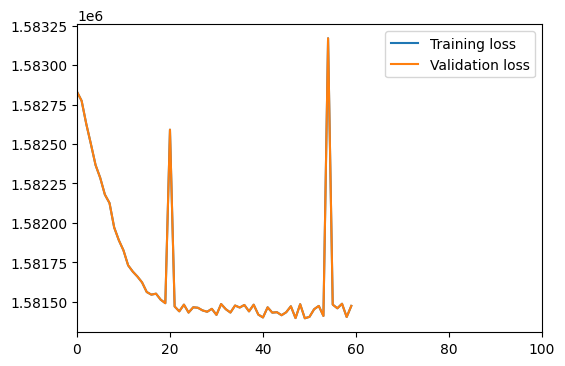

In [107]:
mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

# Training loop
for epoch in mb:
  x.append(epoch)
  total_loss = torch.Tensor([0.0]).to(device)

  # train
  model.train()
  for batch in progress_bar(train_loader, parent=mb):
    optimizer.zero_grad()
    last_names = batch['last_names'].to(device)
    labels = batch['labels'].to(device)
    lengths = batch['lengths']
    outputs = model(last_names, lengths)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  # decay lr
  scheduler.step()
  mean = total_loss / len(train_loader)
  training_losses.append(mean.cpu())

  # validation
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_loader, parent=mb):
      last_names = batch['last_names'].to(device)
      labels = batch['labels'].to(device)
      lengths = batch['lengths']
      outputs = model(last_names, lengths)
      loss = criterion(outputs, labels)
      validation_loss += loss.item()

  val_mean = validation_loss / len(val_loader)
  validation_losses.append(mean.cpu())
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")

  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/instate_v2/state_lang.pt')
      valid_mean_min = val_mean.item()

  # early stopping
  if early_stopper.early_stop(validation_losses[-1]):
    print(f"Early stopping at epoch {epoch}")
    break

In [ ]:
!curl ntfy.sh/c -d "training done"

In [21]:
# load the model

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/instate_v2/state_lang.pt'))

<All keys matched successfully>

In [22]:
langs = df.columns.to_list()
# remove first element in columns
langs.pop(0)

'last_name'

In [23]:
len(langs)

37

In [57]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 100.0 MB/s eta 0:00:00


In [59]:
from Levenshtein import distance

# Calculating the Levenshtein Distance in Python
str1 = 'kitten'
str2 = 'sitting'

dist = distance(str1, str2)
print(f'The Levenshtein distance is {dist}.')

The Levenshtein distance is 3.


In [80]:
len(test_df)

78309

In [83]:
total_matches = 0
test_df_sample = test_df.sample(n=1000, random_state=42)

# for every lastname in test dataset find the nearest names in train dataset
for lastname in test_df_sample['last_name']:
  # use edit distance find top 3 nearest names
  distances = train_df['last_name'].apply(lambda x: distance(lastname, x))
  nearest_lang = train_df.loc[distances.nsmallest(3).index, langs].sum().idxmax()
  actual_lang = test_df_sample.loc[test_df['last_name'] == lastname, langs].values[0].argmax()
  if nearest_lang == langs[actual_lang]:
    total_matches += 1
  # sum the rest of the columns

print(f"Total records: {len(test_df_sample)}")
print(f"Total matches: {total_matches}")
print(f"Percent of matches: {total_matches / len(test_df_sample)}")

Total records: 1000
Total matches: 679
Percent of matches: 0.679


In [108]:
# what if everything is predicted as hindi
total_hindi_matches = 0

for batch in test_loader:
  last_names = batch['last_names'].to(device)
  labels = batch['labels'].to(device)
  _, true = torch.max(labels, 1)
  hindi_tensor = torch.zeros(true.size()[0]) + langs.index('hindi')
  hindi_matches = (hindi_tensor.to(device) == true).sum().item()
  total_hindi_matches += hindi_matches

print(f"Total records: {len(test_df)}")
print(f"Total hindi matches: {total_hindi_matches}")
print(f"Percent of hindi matches: {total_hindi_matches / len(test_df)}")

Total records: 73166
Total hindi matches: 13142
Percent of hindi matches: 0.17961894869201542


In [109]:
# verify on test dataset
model.eval()
total_matches = 0

with torch.no_grad():
  for batch in test_loader:
    last_names = batch['last_names'].to(device)
    labels = batch['labels'].to(device)
    lengths = batch['lengths']
    outputs = model(last_names, lengths)
    # find the max index on each row
    _, predicted = torch.max(outputs, 1)
    _, true = torch.max(labels, 1)
    # count matches between predicted and true
    matches = (predicted == true).sum().item()
    total_matches += matches

# find ratio between matches and actual
ratio = total_matches / len(test_df)
print(f"Total records: {len(test_df)}")
print(f"Total matches: {total_matches}")
print(f"Percent of matches: {ratio}")

Total records: 73166
Total matches: 31021
Percent of matches: 0.42398108411010577


In [110]:
# do inference based on last_name
def infer(lastname):
  with torch.no_grad():
    last_name_indices = [char2idx[char] for char in lastname]
    last_name_tensor = torch.tensor(last_name_indices, dtype=torch.long).unsqueeze(0).to(device)
    lengths = torch.tensor([len(lastname)], dtype=torch.long)
    outputs = model(last_name_tensor, lengths)
    # get top 3 values index of each output
    _, predicted = torch.topk(outputs, 3, dim=1)
    # index them with langs and send actual langs
    pred_langs = []
    for i in range(3):
      pred_langs.append(langs[predicted[0][i].item()])
    pred_scores = []
    for i in range(3):
      pred_scores.append(outputs[0][predicted[0][i].item()].item())
    return pred_langs, pred_scores

In [111]:
infer("sood")

(['hindi', 'bengali', 'urdu'],
 [276.712646484375, 227.44827270507812, 199.8665771484375])

In [112]:
infer("chintalapati")

(['telugu', 'hindi', 'urdu'],
 [6.536921501159668, 3.4749300479888916, 2.0105412006378174])